In [10]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tsai.all import *

In [11]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [12]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [13]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)

print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [6]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays 
Run this section just for the first time

In [13]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

In [14]:
for i, geom in big_pv_geoms_buffer.iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
        
        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        #data_filled['crs'] = data.crs
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)

        ## Clip the farm polygon
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        break        
    except:
         print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.


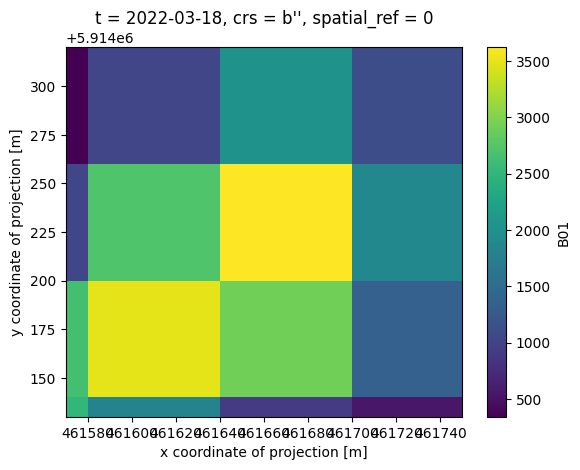

In [15]:
data['B01'][30].plot()

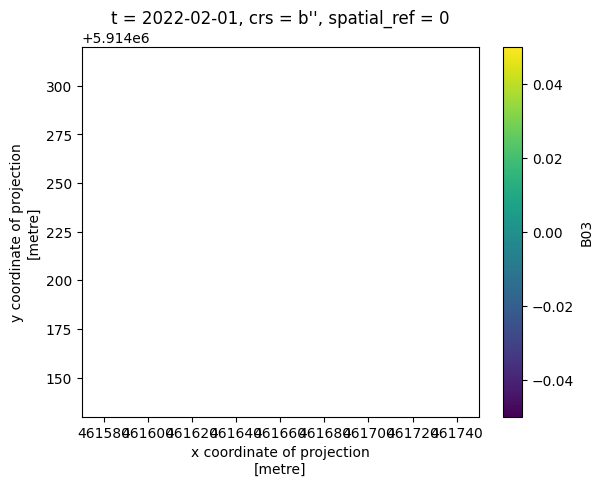

In [16]:
clipped['B03'][12].plot()

In [ ]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

In [16]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [ ]:
pv_samples = np.vstack(all_pixels_ts)
y1 = np.ones(pv_samples.shape[0])

np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [19]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"
start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:1500].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))
        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [20]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

(22551, 11, 365)

In [21]:
y0 = np.zeros(non_pv_samples.shape[0])

In [ ]:
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

#### Combine both PV and Non-PV togehter 

In [78]:
tr_data = np.vstack([pv_samples, non_pv_samples[:12000]])
y = np.hstack([y1, y0[:12000]])

In [79]:
print(tr_data.shape)
print(y.shape)

(20060, 11, 365)
(20060,)


### Modeling

In [22]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

print(pv_samples.shape)
print(non_pv_samples.shape)


(490597, 11, 365)
(320803, 11, 365)


In [23]:

tr_data = np.vstack([pv_samples[:100000], non_pv_samples[:100000]])
del pv_samples, non_pv_samples ; gc.collect()
y = np.hstack([y1[:100000], y0[:100000]])
del y1, y0; gc.collect()

tr_data = np.nan_to_num(tr_data, nan=-999999)

In [24]:
np.unique(y)#shape

array([0., 1.])

In [25]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    X, y, splits = combine_split_data([x_train, x_val], [y_train, y_val])
    
    tfms  = [None, [Categorize()]] #[TSStandardize()] #[None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 16], batch_tfms=[TSStandardize()], num_workers=0)
    break
    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    
    learn.fit_one_cycle(5, lr_max=1e-3)

    # Validation
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    (valid_targets == valid_preds).float().mean()
    score = accuracy_score(valid_preds, valid_targets)
    print(f'Accuracy Score: {score}')
    
    learn.export( f'../models/non_temporal_models/Inception_time_non_temporal_{i+1}.pkl')
    
    i+=1
    break

########### Fold number 1 


In [26]:
del x_train, x_val, y_train, y_val, X, y, splits ; gc.collect()

112

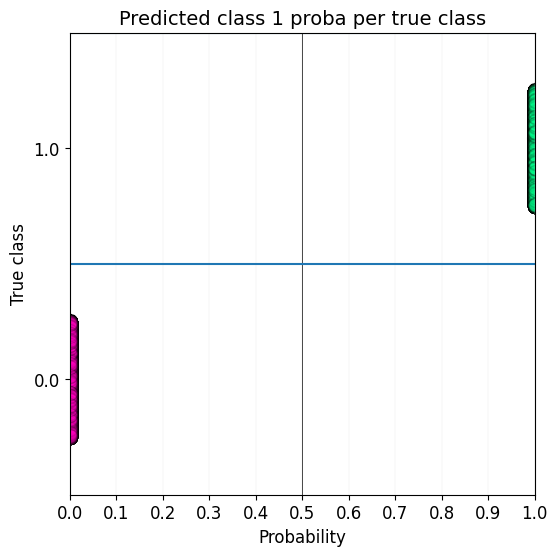

In [27]:
learn.show_probas()

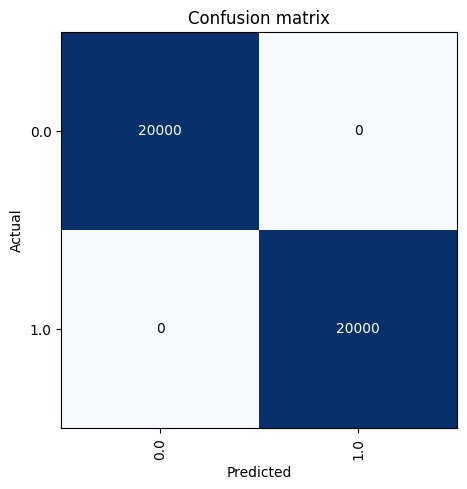

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Inference


#### Extrac the dataset


In [29]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[3:4].iterrows(): #280
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')


        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1)) 
        break
    
    except:
        print(f"This polygon id: {i} is not exist.")

In [30]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

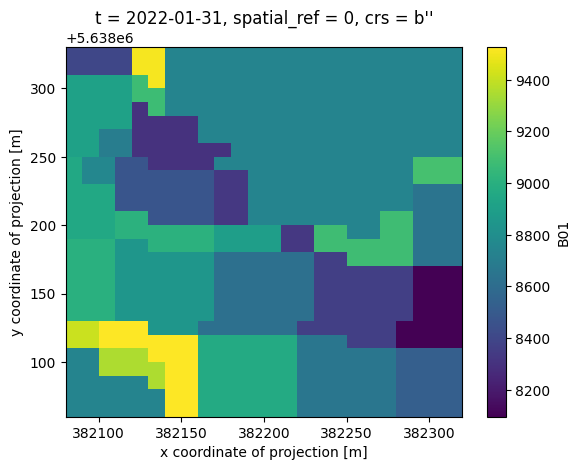

In [31]:
ds_daily_interp['B01'][30].plot()

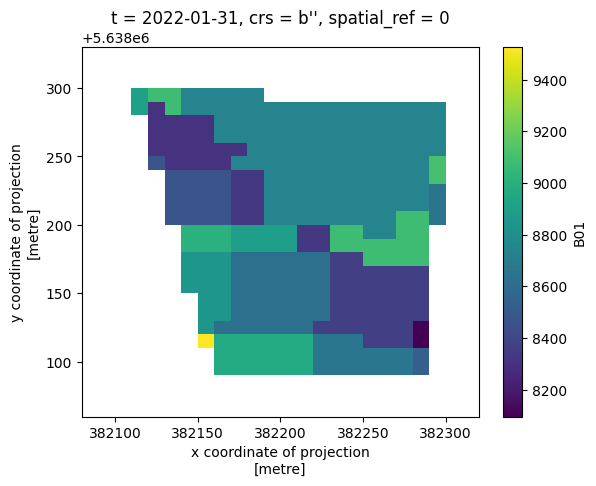

In [32]:
clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
clipped['B01'][30].plot()

In [33]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [34]:
te_samples.shape

(648, 11, 365)

In [35]:
test_ds = dls.dataset.add_test(te_samples)

In [39]:
InceptionTime_model = load_learner(f'../models/non_temporal_models/Inception_time_non_temporal_1.pkl', cpu=False)

In [40]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)

In [41]:
te_pred = np.array(np.argmax(test_probas, axis=1))
te_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

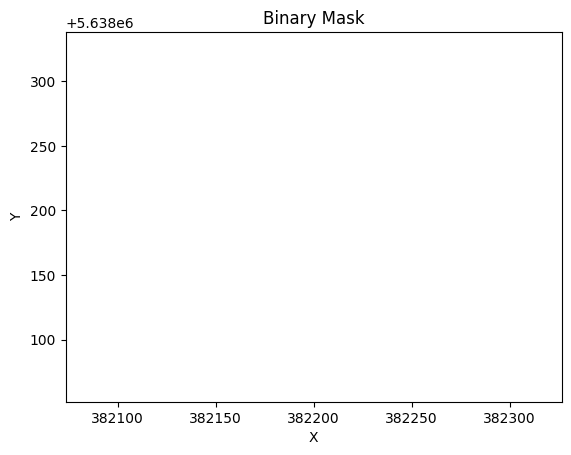

In [43]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap([ 'white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()

#### Inference all dataset

In [18]:
InceptionTime_model = load_learner(f'../models/non_temporal_models/Inception_time_non_temporal_1.pkl', cpu=False)

In [16]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

In [17]:
te_data = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [28]:
test_ds = dls.dataset.add_test(te_data)

In [31]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)

In [32]:
te_pred = np.array(np.argmax(test_probas, axis=1))

In [33]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.8358162264756062


In [37]:
## Predict just the photovoltaic pixels
test_ds = dls.dataset.add_test(te_pv_samples)
y1 = np.ones(te_pv_samples.shape[0])

test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)

te_pred = np.array(np.argmax(test_probas, axis=1))
test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.35139261744966444
